# EVALUATION OF STREAMING GIANT NETFLIX'S CONTENT

In [1]:
from datasets import load_dataset

ds = load_dataset("hugginglearners/netflix-shows")

In [2]:
# Loading necessary libraries: 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from plotly.subplots import make_subplots

## Dataset Loading and Description

In [3]:
# Converting the DatasetDict to Pandas Dataframe
netflix_df = ds['train'].to_pandas()

In [4]:
# Dataset Head
netflix_df.head()

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",None,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,None,None,None,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [5]:
# Dataset Information
netflix_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB


In [6]:
# Creating a copy to not modify the original dataset
df = netflix_df.copy()

# Display basic info
print("Dataset Overview:")
print(f"Shape: {df.shape}")

Dataset Overview:
Shape: (8807, 12)


In [7]:
print("\nData Types:")
print(df.dtypes)


Data Types:
show_id         object
type            object
title           object
director        object
cast            object
country         object
date_added      object
release_year     int64
rating          object
duration        object
listed_in       object
description     object
dtype: object


In [8]:
# Check for duplicates
print(f"\nDuplicate entries: {df.duplicated().sum()}")


Duplicate entries: 0


In [9]:
print(df.isnull().sum())

show_id            0
type               0
title              0
director        2634
cast             825
country          831
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
dtype: int64


## Data Pre-processing and Cleaning

### Handling Null Values

#### Finding the null % of the values. If the % exceeds 50, then it's better to drop the rows. 

In [10]:
null_percentages = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
print("Percentage of missing values in each column:")
print(null_percentages)

Percentage of missing values in each column:
director        29.908028
country          9.435676
cast             9.367549
date_added       0.113546
rating           0.045418
duration         0.034064
show_id          0.000000
type             0.000000
title            0.000000
release_year     0.000000
listed_in        0.000000
description      0.000000
dtype: float64


#### Column "Director", "Cast", and "Country"

Keeping the null values as "Unknown" is generally a good approach for future analysis due to the following reasons: 
1. "Unknown" can be used instead of dropping these entries, a full dataset can be maintained to perform proper analytics.
2. When analysing based on these columns, for eg,  "Unknown Director" will simply appear as its own category. This is more informative than excluding these entries.
3. Having a distinct "Unknown" category helps in analyzing whether there are patterns associated with missing director information. For example, we might discover that certain genres or countries are more likely to have missing director data 

In [11]:
df['director'] = df['director'].fillna('Unknown Director')
df['cast'].fillna('Unknown Cast', inplace=True)
df['country'].fillna('Unknown Country', inplace=True)

#### Column "date_added", "rating", "duration"

For preserving data:
1. Filling the date_added column with median date.
2. Filling the rating column with mode data (most common rating)
3. Filling the duration column with median data seperately for Movies and TV shows

In [12]:
df['date_added'] = pd.to_datetime(df['date_added'], errors='coerce')
median_date = df['date_added'].dropna().median()
df['date_added'] = df['date_added'].fillna(median_date)

most_common_rating = df['rating'].mode()[0]
df['rating'] = df['rating'].fillna(most_common_rating)

In [13]:
df['duration_value'] = df['duration'].str.extract('(\\d+)').astype(float)
df['duration_unit'] = df['duration'].str.extract('(\\d+)\\s+(\\w+)')[1]

In [14]:
median_movie_duration = df[df['type'] == 'Movie']['duration_value'].dropna().median()
median_tv_duration = df[df['type'] == 'TV Show']['duration_value'].dropna().median()

# Fill missing durations based on content type
for idx in df[df['duration_value'].isnull()].index:
    if df.loc[idx, 'type'] == 'Movie':
        df.loc[idx, 'duration_value'] = median_movie_duration
    else:
        df.loc[idx, 'duration_value'] = median_tv_duration

In [15]:
# Extract year and month from date_added
df['year_added'] = df['date_added'].dt.year
df['month_added'] = df['date_added'].dt.month

### Outlier Detection and Handling

#### Anomalies in the "duration value": Identifying Extremely Short or Long Movies and TV Shows

**Why is it important?**
1. Detecting and handling outliers ensures that unusual values do not skew the analysis.
2. Extreme cases can distort insights, leading to misleading interpretations that do not reflect the true trends in the data.

**How are these outliers handled?**

There are multiple ways to handle an outlier, but here, capping is done. 

*Capping:* a technique used to limit extreme values by setting predefined upper and lower bounds. This helps reduce the impact of outliers without completely removing them.

**Why is capping used?**

1. Preserves Data Volume - By capping rather than removing the 450 outlier movies (7.3% of the data), we can maintain the full dataset size of 6,128 movies. This gives the analysis more statistical power and prevents information loss.
2. Maintains Real-World Patterns - Those extremely short or long movies represent actual content in Netflix's library. Capping preserves their existence in your analysis while reducing their extreme influence on calculations. For example, a 300-minute movie still appears as a "long movie" (at 154.5 minutes) rather than disappearing entirely.


##### Outliers in "Movies" content type

In [16]:
# Filter the movies
movies = df[(df['type'] == 'Movie') & (df['duration_unit'] == 'min')]

# Calculate IQR for movie durations
q1_movie = movies['duration_value'].quantile(0.25)
q3_movie = movies['duration_value'].quantile(0.75)
iqr_movie = q3_movie - q1_movie
lower_bound_movie = q1_movie - 1.5 * iqr_movie
upper_bound_movie = q3_movie + 1.5 * iqr_movie

# Identify outliers
movie_outliers = movies[(movies['duration_value'] < lower_bound_movie) | (movies['duration_value'] > upper_bound_movie)]

print(f"Movie Duration Outliers: {len(movie_outliers)} entries out of {len(movies)} movies")

Movie Duration Outliers: 450 entries out of 6128 movies


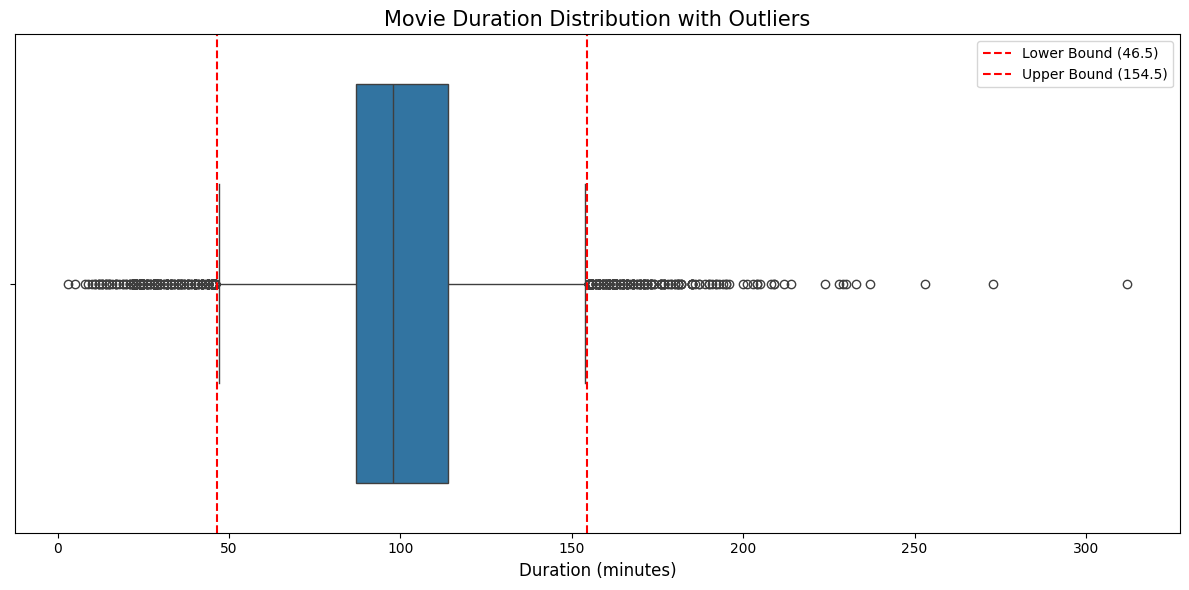

In [17]:
# Box plot to visualise the outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x=movies['duration_value'])
plt.title('Movie Duration Distribution with Outliers', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.axvline(x=lower_bound_movie, color='red', linestyle='--', label=f'Lower Bound ({lower_bound_movie:.1f})')
plt.axvline(x=upper_bound_movie, color='red', linestyle='--', label=f'Upper Bound ({upper_bound_movie:.1f})')
plt.legend()
plt.tight_layout()

Text(0, 0.5, 'Count')

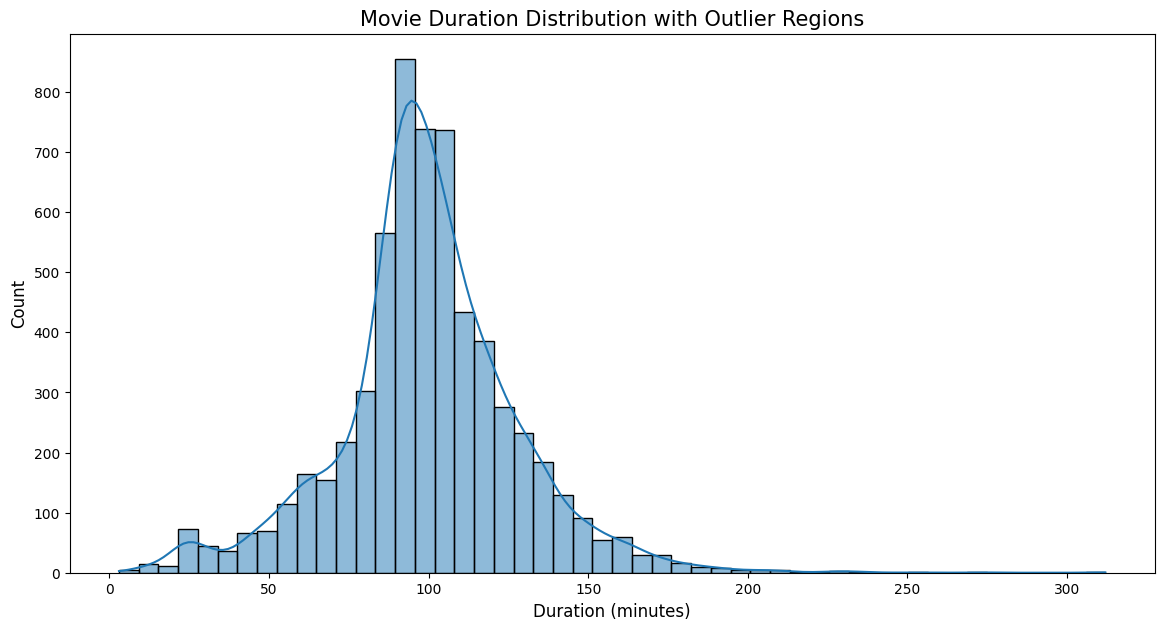

In [18]:
# Distribution plot with outlier regions highlighted
plt.figure(figsize=(14, 7))
sns.histplot(movies['duration_value'], bins=50, kde=True)
plt.title('Movie Duration Distribution with Outlier Regions', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Count', fontsize=12)

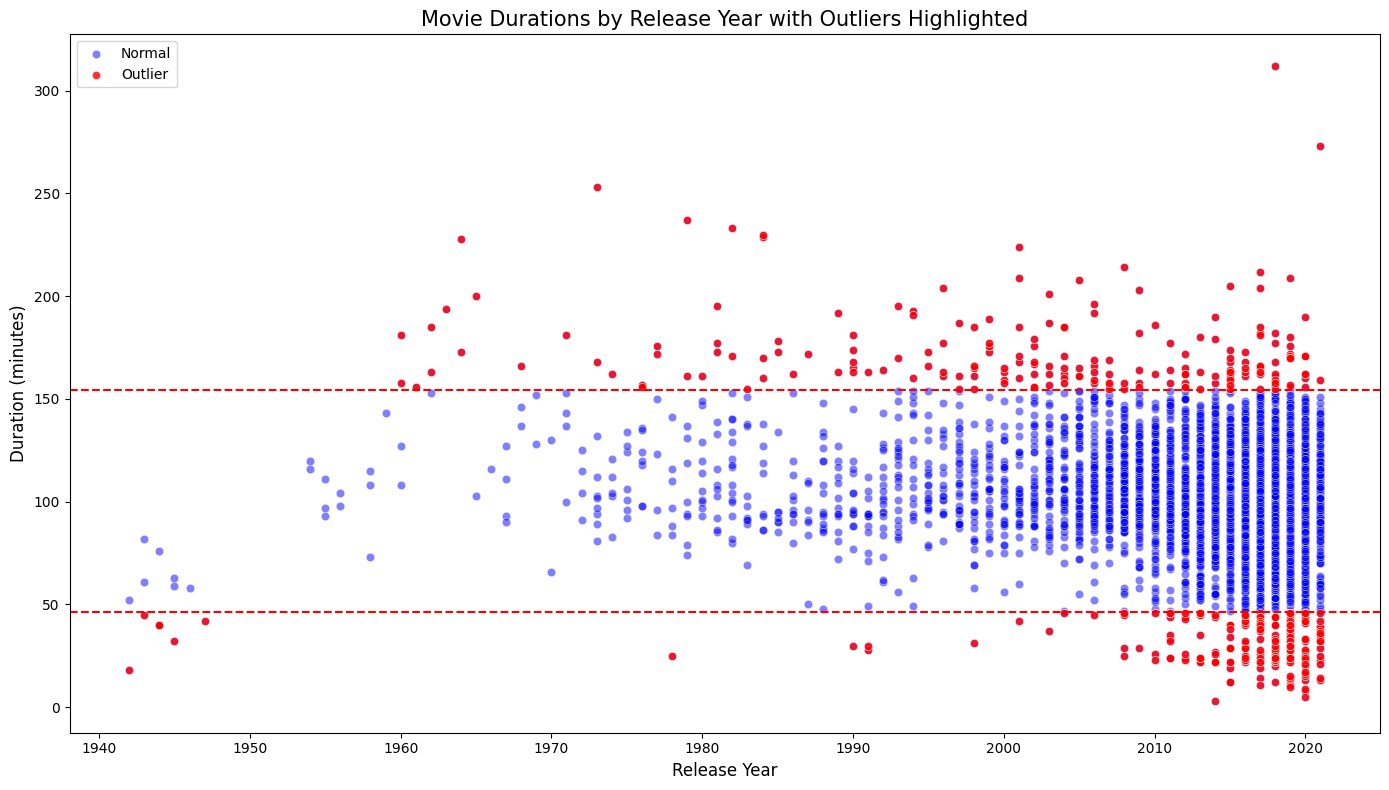

In [19]:
plt.figure(figsize=(14, 8))
sns.scatterplot(data=movies, x='release_year', y='duration_value', alpha=0.5, color='blue', label='Normal')
sns.scatterplot(data=movie_outliers, x='release_year', y='duration_value', alpha=0.8, color='red', label='Outlier')
plt.title('Movie Durations by Release Year with Outliers Highlighted', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Duration (minutes)', fontsize=12)
plt.axhline(y=lower_bound_movie, color='red', linestyle='--')
plt.axhline(y=upper_bound_movie, color='red', linestyle='--')
plt.legend()
plt.tight_layout()

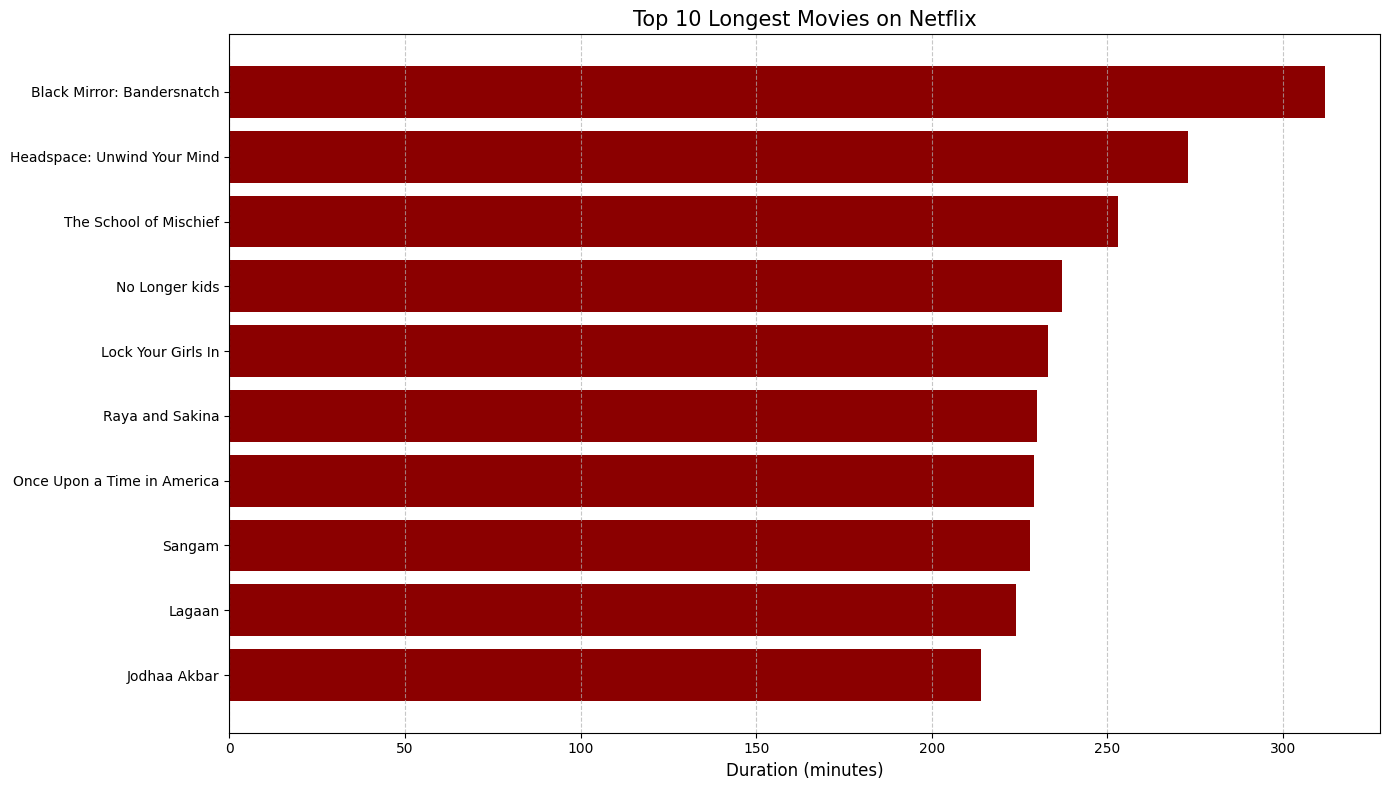

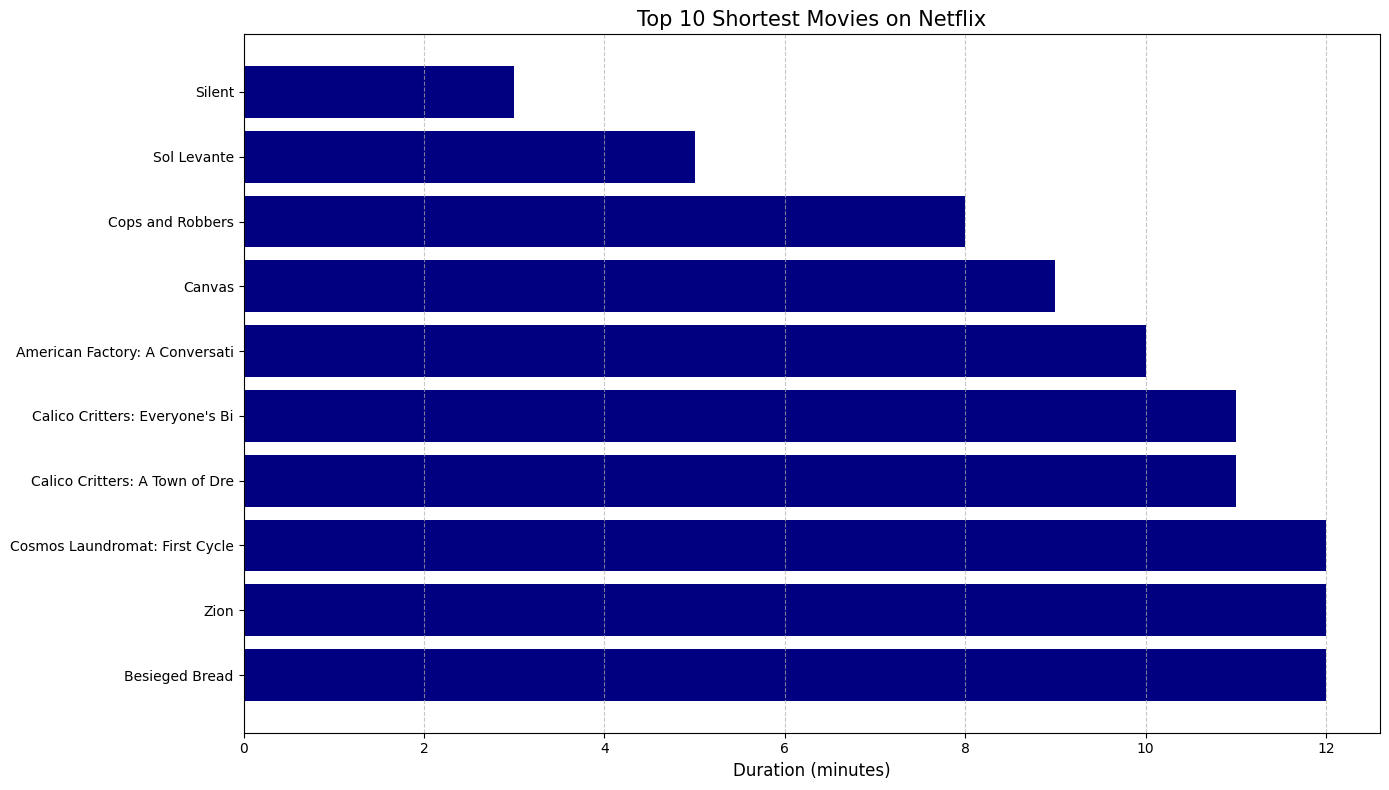

In [20]:
# Top 10 longest and shortest movies
longest_movies = movies.sort_values('duration_value', ascending=False).head(10)
shortest_movies = movies.sort_values('duration_value').head(10)

# Plot top 10 longest movies
plt.figure(figsize=(14, 8))
bars = plt.barh(longest_movies['title'].str.slice(0, 30), longest_movies['duration_value'], color='darkred')
plt.xlabel('Duration (minutes)', fontsize=12)
plt.title('Top 10 Longest Movies on Netflix', fontsize=15)
plt.gca().invert_yaxis()  # To have the longest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Plot top 10 shortest movies
plt.figure(figsize=(14, 8))
bars = plt.barh(shortest_movies['title'].str.slice(0, 30), shortest_movies['duration_value'], color='navy')
plt.xlabel('Duration (minutes)', fontsize=12)
plt.title('Top 10 Shortest Movies on Netflix', fontsize=15)
plt.gca().invert_yaxis()  # To have the shortest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

##### Handling Outliers

/var/folders/zk/gt6dlj713295ct5gwkvq9pp40000gn/T/ipykernel_68104/663703105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['duration_capped'] = movies['duration_value'].copy()


Text(0.5, 0, 'Duration (minutes)')

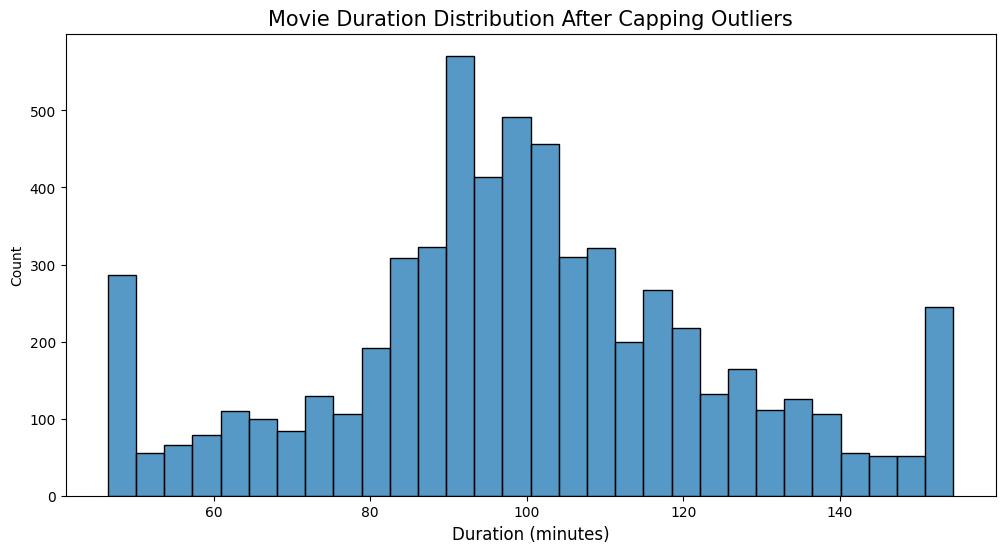

In [21]:
# Create a capped version of the duration for analysis
movies['duration_capped'] = movies['duration_value'].copy()

# Cap at lower and upper bounds
movies.loc[movies['duration_value'] < lower_bound_movie, 'duration_capped'] = lower_bound_movie
movies.loc[movies['duration_value'] > upper_bound_movie, 'duration_capped'] = upper_bound_movie

# Visualize the distribution after capping
plt.figure(figsize=(12, 6))
sns.histplot(data=movies, x='duration_capped', bins=30)
plt.title('Movie Duration Distribution After Capping Outliers', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)

##### Outliers in "TV Show" content type

In [23]:
# Filter TV shows
tv_shows = df[(df['type'] == 'TV Show') & (df['duration_unit'] == 'Seasons')]

# Calculate IQR for TV show seasons
q1_tv = tv_shows['duration_value'].quantile(0.25)
q3_tv = tv_shows['duration_value'].quantile(0.75)
iqr_tv = q3_tv - q1_tv
lower_bound_tv = q1_tv - 1.5 * iqr_tv
upper_bound_tv = q3_tv + 1.5 * iqr_tv

# Identify outliers
tv_outliers = tv_shows[(tv_shows['duration_value'] < lower_bound_tv) | (tv_shows['duration_value'] > upper_bound_tv)]

print(f"TV Show Season Outliers: {len(tv_outliers)} entries out of {len(tv_shows)} TV shows")

TV Show Season Outliers: 43 entries out of 883 TV shows


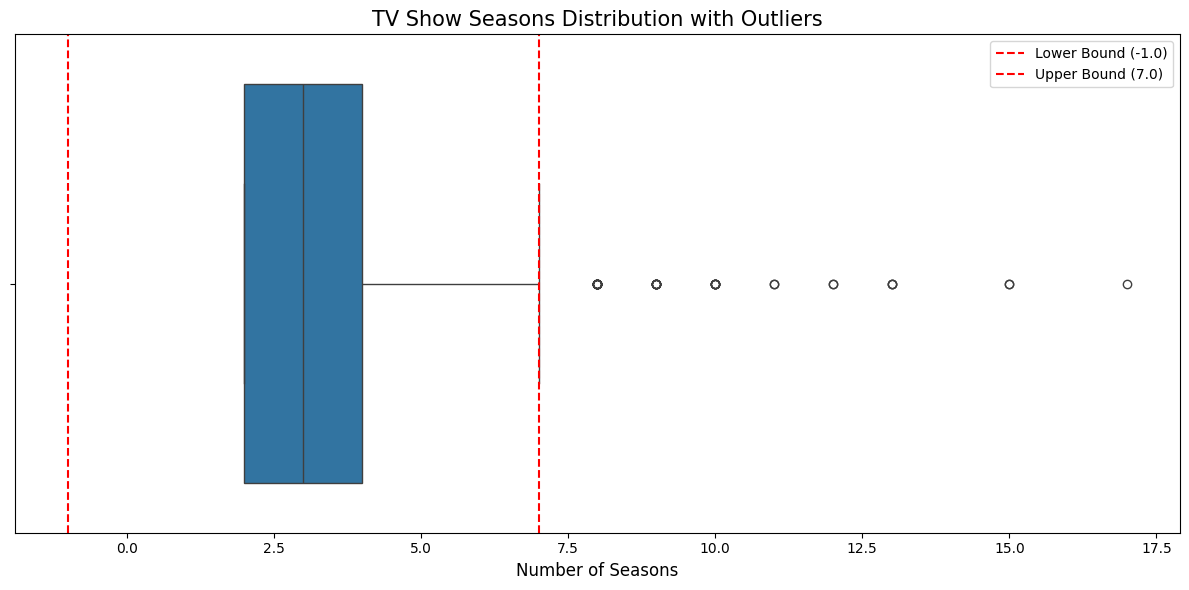

In [24]:
# Box plot with outliers highlighted
plt.figure(figsize=(12, 6))
sns.boxplot(x=tv_shows['duration_value'])
plt.title('TV Show Seasons Distribution with Outliers', fontsize=15)
plt.xlabel('Number of Seasons', fontsize=12)
plt.axvline(x=lower_bound_tv, color='red', linestyle='--', label=f'Lower Bound ({lower_bound_tv:.1f})')
plt.axvline(x=upper_bound_tv, color='red', linestyle='--', label=f'Upper Bound ({upper_bound_tv:.1f})')
plt.legend()
plt.tight_layout()

Text(0, 0.5, 'Count')

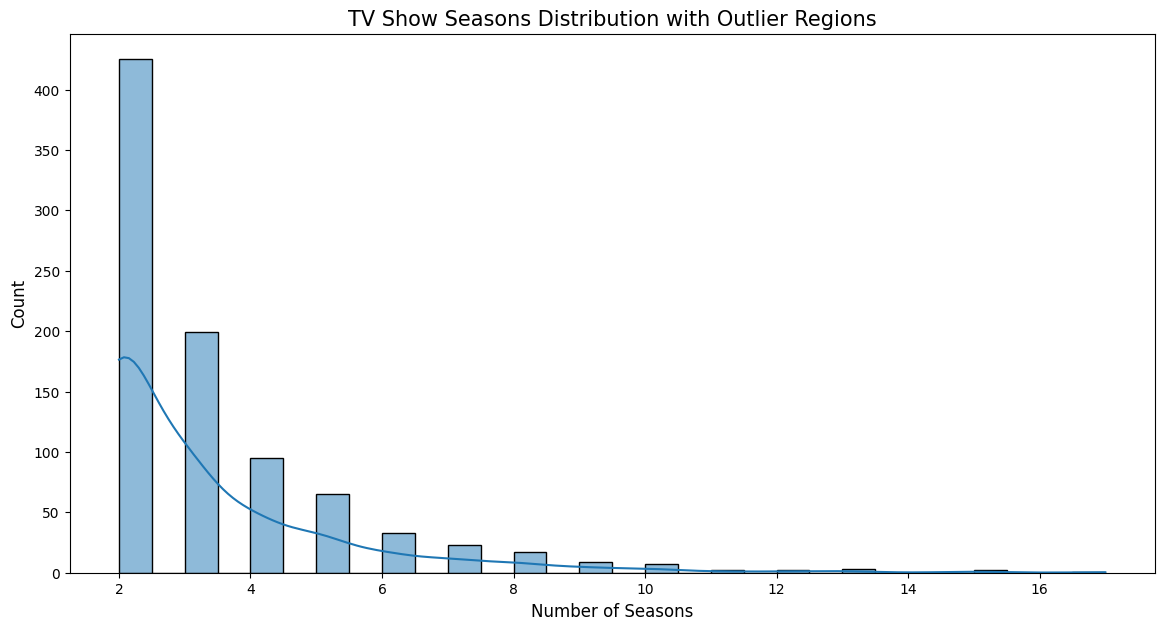

In [25]:
# Distribution plot with outlier regions highlighted
plt.figure(figsize=(14, 7))
sns.histplot(tv_shows['duration_value'], bins=30, kde=True)
plt.title('TV Show Seasons Distribution with Outlier Regions', fontsize=15)
plt.xlabel('Number of Seasons', fontsize=12)
plt.ylabel('Count', fontsize=12)

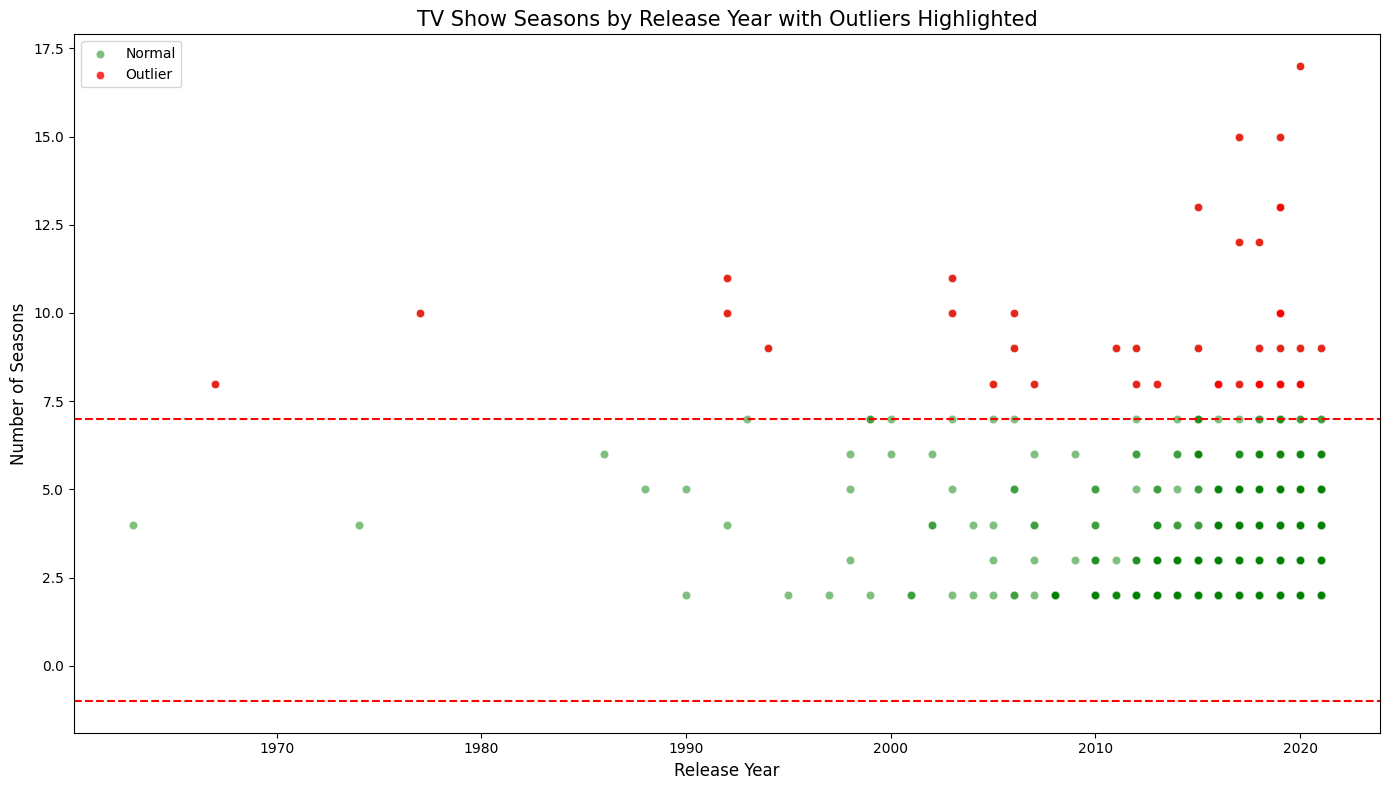

In [52]:
# Scatter plot of TV show seasons by release year with outliers highlighted
plt.figure(figsize=(14, 8))
sns.scatterplot(data=tv_shows, x='release_year', y='duration_value', alpha=0.5, color='green', label='Normal')
sns.scatterplot(data=tv_outliers, x='release_year', y='duration_value', alpha=0.8, color='red', label='Outlier')
plt.title('TV Show Seasons by Release Year with Outliers Highlighted', fontsize=15)
plt.xlabel('Release Year', fontsize=12)
plt.ylabel('Number of Seasons', fontsize=12)
plt.axhline(y=lower_bound_tv, color='red', linestyle='--')
plt.axhline(y=upper_bound_tv, color='red', linestyle='--')
plt.legend()
plt.tight_layout()

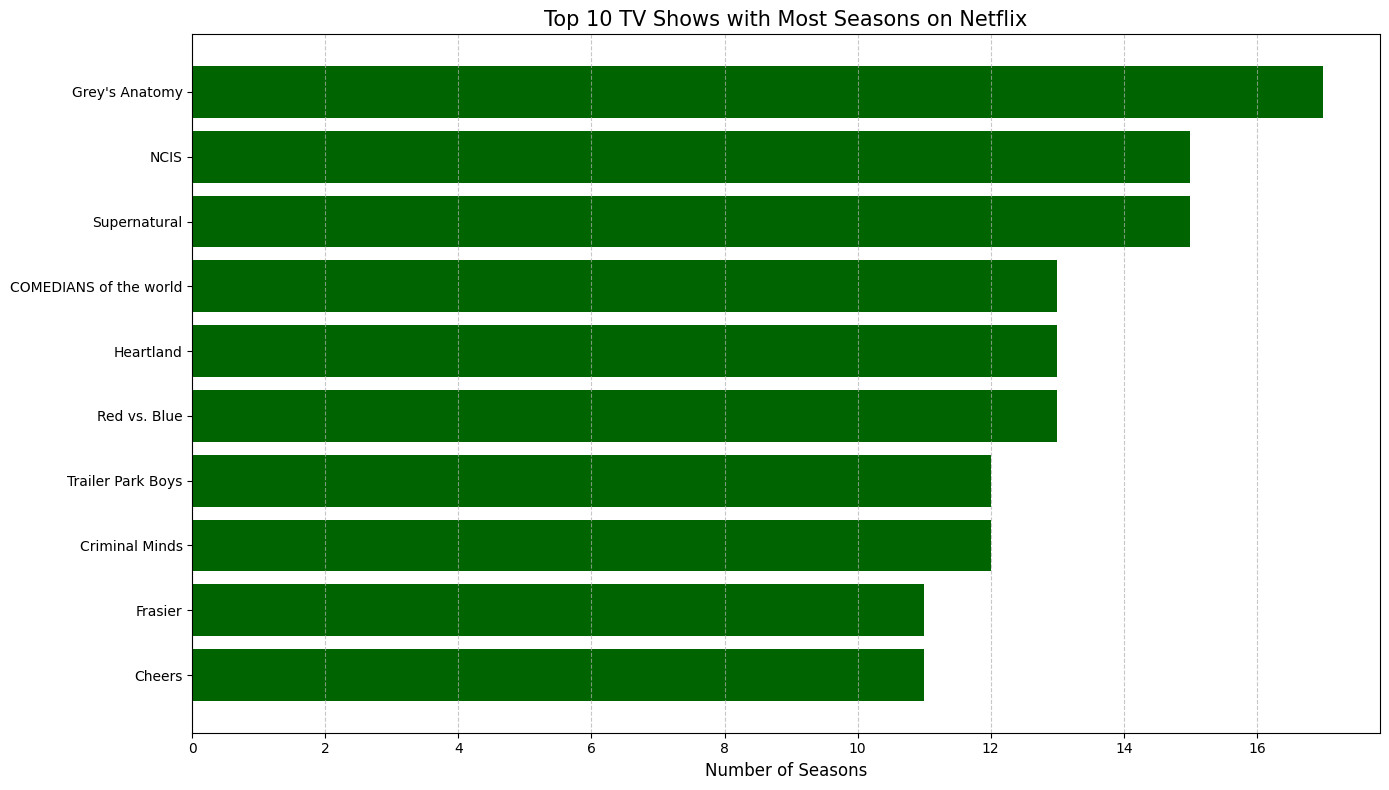

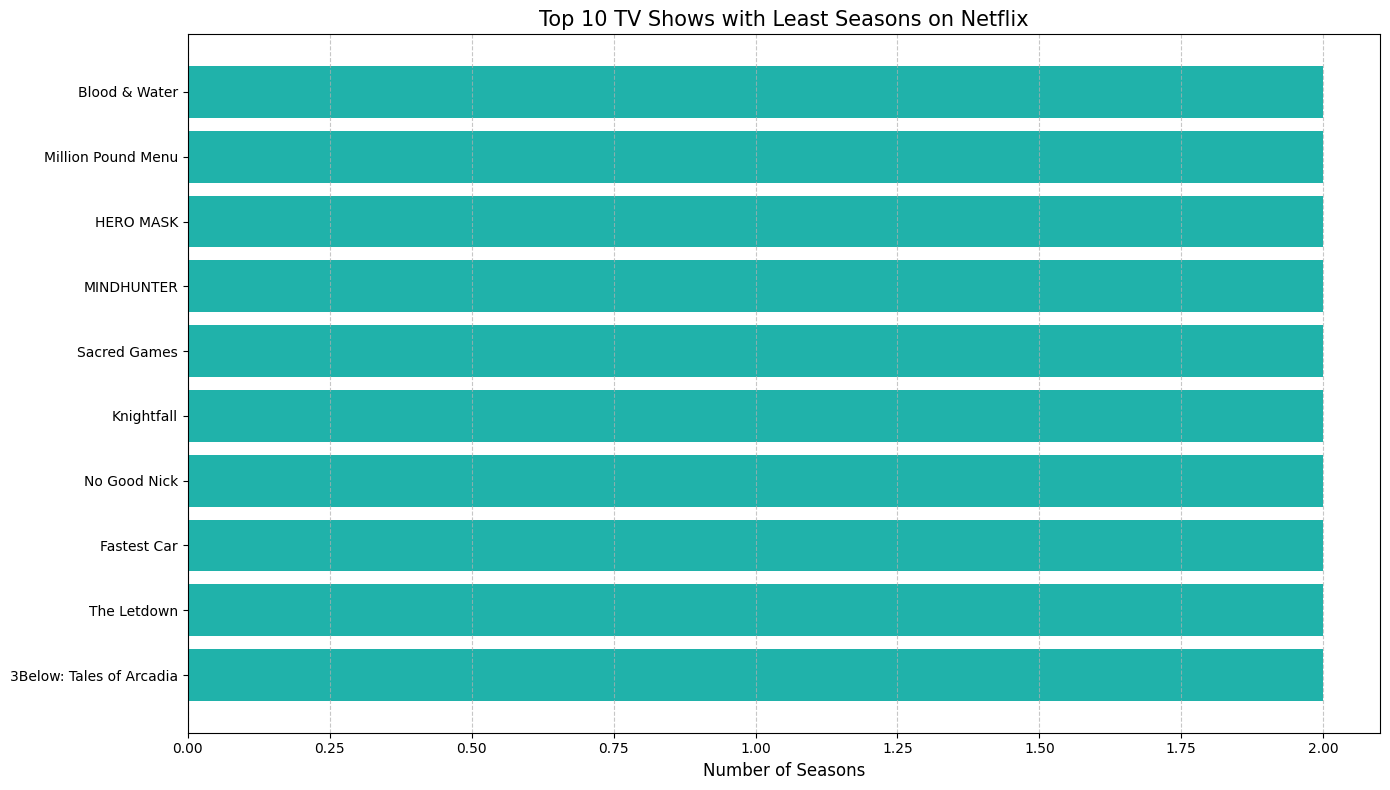

In [27]:
# Top TV shows with most seasons
most_seasons = tv_shows.sort_values('duration_value', ascending=False).head(10)
least_seasons = tv_shows.sort_values('duration_value').head(10)


# TV shows with most seasons
plt.figure(figsize=(14, 8))
bars = plt.barh(most_seasons['title'].str.slice(0, 30), most_seasons['duration_value'], color='darkgreen')
plt.xlabel('Number of Seasons', fontsize=12)
plt.title('Top 10 TV Shows with Most Seasons on Netflix', fontsize=15)
plt.gca().invert_yaxis()  # To have the highest at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# TV shows with least seasons
plt.figure(figsize=(14, 8))
bars = plt.barh(least_seasons['title'].str.slice(0, 30), least_seasons['duration_value'], color='lightseagreen')
plt.xlabel('Number of Seasons', fontsize=12)
plt.title('Top 10 TV Shows with Least Seasons on Netflix', fontsize=15)
plt.gca().invert_yaxis()  # To have the show with least seasons at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

##### Handling outliers

/var/folders/zk/gt6dlj713295ct5gwkvq9pp40000gn/T/ipykernel_68104/1394644394.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tv_shows['duration_capped'] = tv_shows['duration_value'].copy()


Text(0.5, 0, 'Duration (Seasons)')

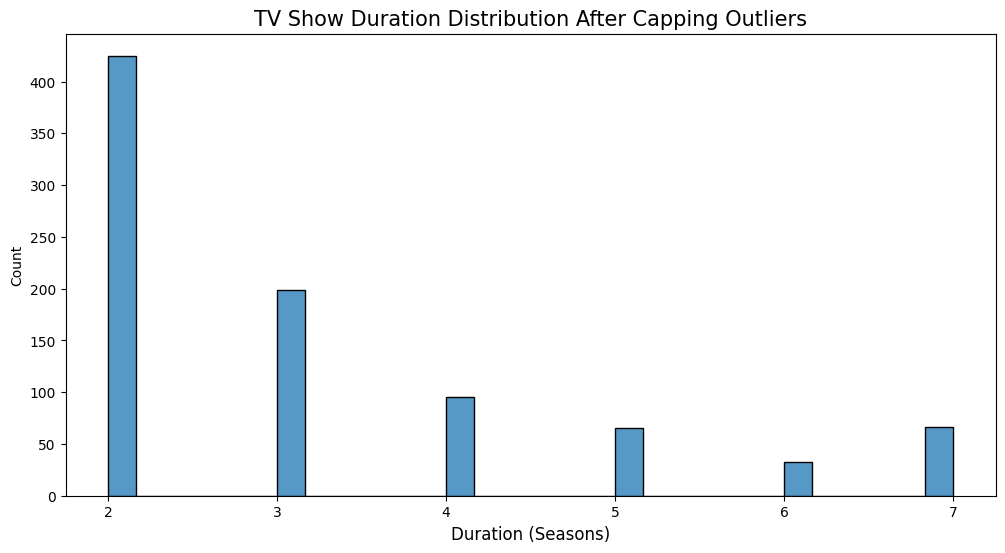

In [28]:
# Create a capped version of the duration for analysis
tv_shows['duration_capped'] = tv_shows['duration_value'].copy()

# Cap at lower and upper bounds
tv_shows.loc[tv_shows['duration_value'] < lower_bound_tv, 'duration_capped'] = lower_bound_tv
tv_shows.loc[tv_shows['duration_value'] > upper_bound_tv, 'duration_capped'] = upper_bound_tv

# Visualize the distribution after capping
plt.figure(figsize=(12, 6))
sns.histplot(data=tv_shows, x='duration_capped', bins=30)
plt.title('TV Show Duration Distribution After Capping Outliers', fontsize=15)
plt.xlabel('Duration (Seasons)', fontsize=12)

In [29]:
df_final = pd.concat([movies, tv_shows], ignore_index=True)

In [30]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7011 entries, 0 to 7010
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   show_id          7011 non-null   object        
 1   type             7011 non-null   object        
 2   title            7011 non-null   object        
 3   director         7011 non-null   object        
 4   cast             7011 non-null   object        
 5   country          7011 non-null   object        
 6   date_added       7011 non-null   datetime64[ns]
 7   release_year     7011 non-null   int64         
 8   rating           7011 non-null   object        
 9   duration         7011 non-null   object        
 10  listed_in        7011 non-null   object        
 11  description      7011 non-null   object        
 12  duration_value   7011 non-null   float64       
 13  duration_unit    7011 non-null   object        
 14  year_added       7011 non-null   int32  

## Exploratory Data Analysis (Visualisation and Insights)

### Pivot Tables

In [31]:
top_countries = df_final['country'].value_counts().head(15).index.tolist()
country_df = df_final[df_final['country'].isin(top_countries)].copy()

# pivot table for content type by country
country_pivot = pd.pivot_table(
    country_df,
    index='country',
    columns='type',
    values='show_id',
    aggfunc='count',
    fill_value=0
)

# Add totals and percentages
country_pivot['Total'] = country_pivot.sum(axis=1)
country_pivot['Movie %'] = (country_pivot['Movie'] / country_pivot['Total'] * 100).round(1)
country_pivot['TV Show %'] = (country_pivot['TV Show'] / country_pivot['Total'] * 100).round(1)
country_pivot = country_pivot.sort_values('Total', ascending=False)

print("\nContent Distribution by Top 15 Countries")
print(country_pivot)


Content Distribution by Top 15 Countries
type                           Movie  TV Show  Total  Movie %  TV Show %
country                                                                 
United States                   2055      358   2413     85.2       14.8
India                            893        9    902     99.0        1.0
Unknown Country                  440       56    496     88.7       11.3
United Kingdom                   206       82    288     71.5       28.5
Canada                           122       40    162     75.3       24.7
Japan                             76       59    135     56.3       43.7
Spain                             97       20    117     82.9       17.1
Egypt                             92        0     92    100.0        0.0
Nigeria                           86        3     89     96.6        3.4
France                            75       13     88     85.2       14.8
Turkey                            76        9     85     89.4       10.6
Mexico   

<Figure size 1400x800 with 0 Axes>

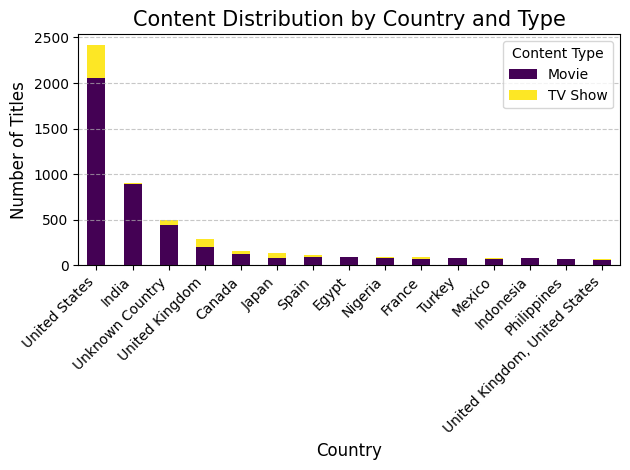

In [32]:
plt.figure(figsize=(14, 8))
country_data = country_pivot.drop(['Movie %', 'TV Show %', 'Total'], axis=1)
country_data.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Content Distribution by Country and Type', fontsize=15)
plt.xlabel('Country', fontsize=12)
plt.ylabel('Number of Titles', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Content Type')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

Dominance of the United States:
- The U.S. has the highest number of titles (2,413), with 85.2% being movies and 14.8% TV shows. 
- This reflects Netflix's strong focus on the U.S. market, likely due to its origin and large subscriber base.

India's Movie-Centric Catalog: 
- India has the second-highest total (902 titles), but 99% are movies. 
- This aligns with Bollywood's prolific movie production and local audience preferences. 

TV Show Popularity in the UK and Japan: 
- The UK (26.5% TV shows) and Japan (43.7% TV shows) stand out for higher TV show ratios, suggesting regional demand for serialized content or local productions. 	

Gaps in Certain Markets: 
- Egypt and the Philippines have almost no TV shows (0% or near 0%), indicating potential untapped opportunities or cultural preferences for movies.

In [33]:
# time periods for analysis
year_bins = [1900, 1960, 1970, 1980, 1990, 2000, 2010, 2015, 2020, 2025]
year_labels = ['Pre-1960', '1960s', '1970s', '1980s', '1990s', '2000s', '2010-2014', '2015-2019', '2020+']

df_final['release_period'] = pd.cut(df_final['release_year'], bins=year_bins, labels=year_labels)

# Create pivot table of content by release period and type
release_pivot = pd.pivot_table(
    df_final,
    index='release_period',
    columns='type',
    values='show_id',
    aggfunc='count',
    fill_value=0
)

# Add totals and percentage columns
release_pivot['Total'] = release_pivot.sum(axis=1)
release_pivot.loc['Total'] = release_pivot.sum()

print("\nContent Distribution by Release Period and Type")
print(release_pivot)


Content Distribution by Release Period and Type
type            Movie  TV Show  Total
release_period                       
Pre-1960           28        0     28
1960s              21        2     23
1970s              75        2     77
1980s             130        4    134
1990s             255       15    270
2000s             797       52    849
2010-2014        1204      116   1320
2015-2019        3341      580   3921
2020+             277      112    389
Total            6128      883   7011


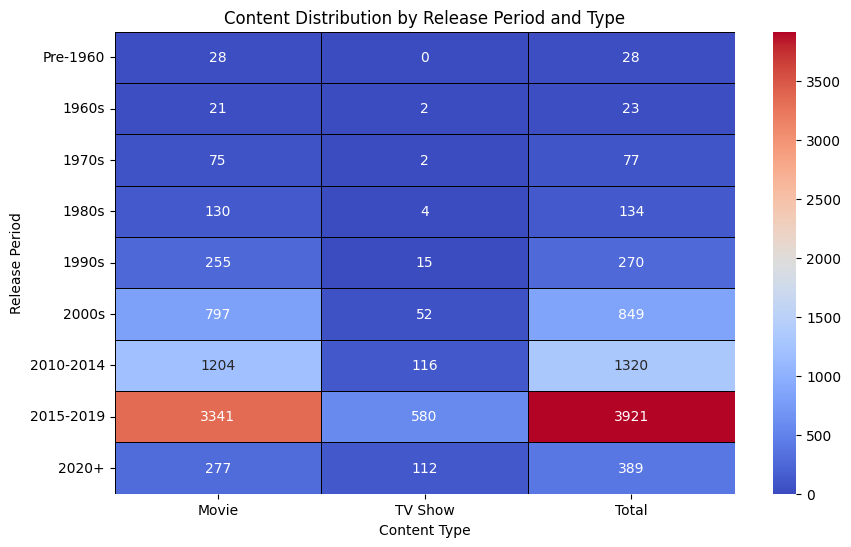

In [34]:
# Drop the 'Total' row for better visualization
release_pivot_filtered = release_pivot.drop("Total")

# Set figure size
plt.figure(figsize=(10, 6))

# Create heatmap with annotations
sns.heatmap(release_pivot_filtered, annot=True, fmt="d", cmap="coolwarm", linewidths=0.5, linecolor="black")

# Labels and title
plt.xlabel("Content Type")
plt.ylabel("Release Period")
plt.title("Content Distribution by Release Period and Type")

# Show plot
plt.show()

Exponential Growth Post-2010: 
- Over 80% of content was released after 2010, peaking in 2015–2019 (3,921 titles). 
- This correlates with Netflix's global expansion and shift to original productions. 

TV Shows Gaining Traction: 
- TV shows were rare before 2000 but surged post-2015 (580 titles in 2015–2019). 
- This reflects the rise of binge-watching culture and Netflix's investment in series like Stranger Things. 

Recent Slowdown in Movies: 
- The 2020+ period shows fewer movies (277) compared to 2015–2019 (3,341), possibly due to pandemic-related production delays or a strategic pivot toward TV shows.

### Data Visualisation

#### How is netflix's content distributed?

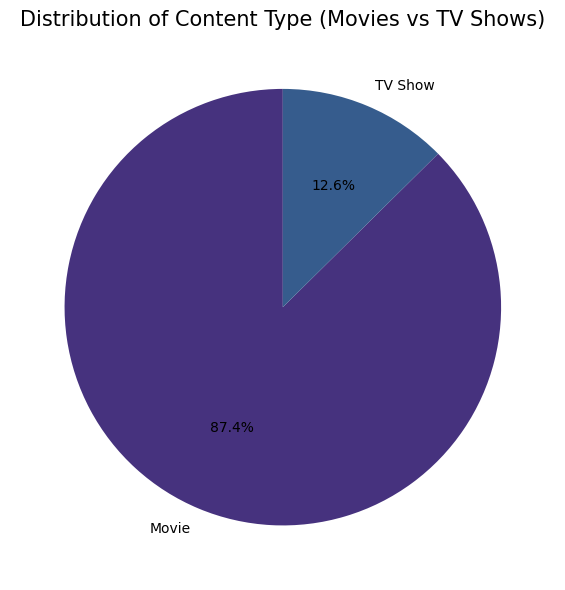

In [35]:
content_type_counts = df_final['type'].value_counts()
fig1, ax1 = plt.subplots(figsize=(10, 6))
ax1.pie(content_type_counts, labels=content_type_counts.index, autopct='%1.1f%%', 
        startangle=90, colors=sns.color_palette('viridis'))
ax1.set_title('Distribution of Content Type (Movies vs TV Shows)', fontsize=15)
plt.tight_layout()

The output shows that the Netflix catalog consists of:
- 6,131 Movies 
- 2,676 TV Shows 

This means approximately 70% of Netflix content consists of movies, while about 30% are TV shows.

#### How much total content is being generated year on year?

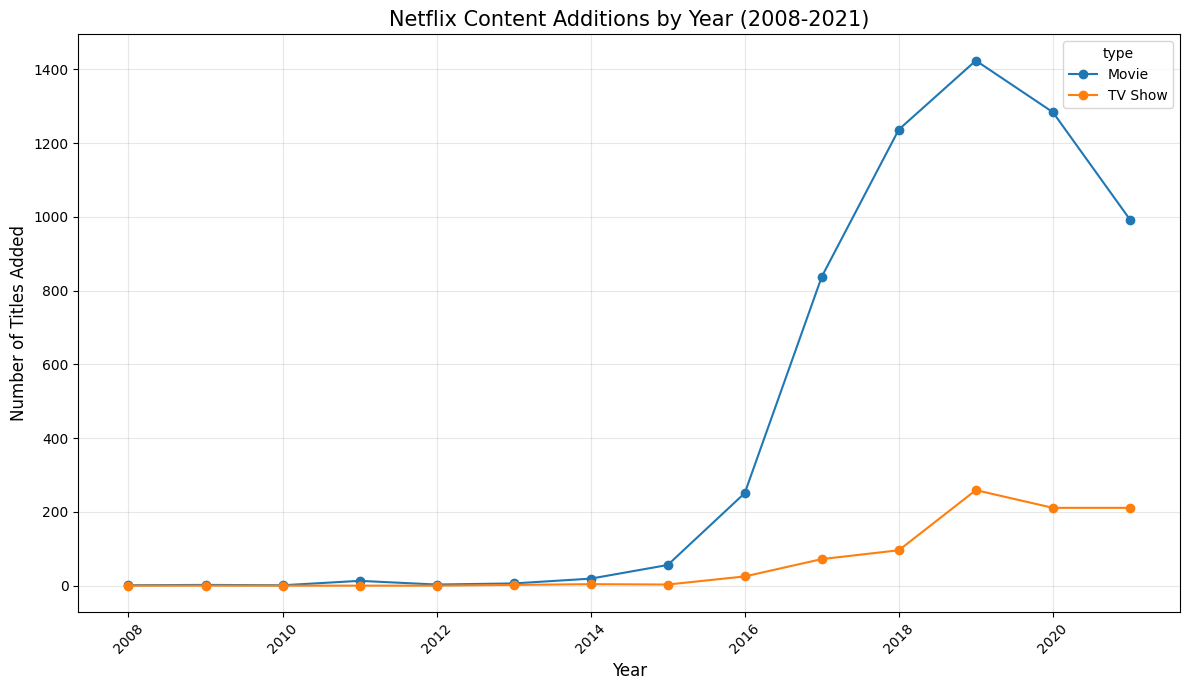

In [38]:
yearly_additions = df_final.groupby(['year_added', 'type']).size().unstack().fillna(0)

fig2, ax2 = plt.subplots(figsize=(12, 7))
yearly_additions.plot(kind='line', marker='o', ax=ax2)
ax2.set_title('Netflix Content Additions by Year (2008-2021)', fontsize=15)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Number of Titles Added', fontsize=12)
ax2.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

Netflix had minimal content additions between 2008-2014, with virtually no TV shows added during this period

Around 2015, content additions began to increase significantly for both movies and TV shows 

The most dramatic growth occurred between 2016 and 2019, showing Netflix's aggressive content acquisition strategy 

Movie additions peaked in 2019 at approximately 1,400 titles 

TV show additions peaked slightly later around 2020 at approximately 600 titles 

Both content types show a decline in 2021, possibly indicating: 
- A change in Netflix's content strategy 
- The impact of COVID-19 on production 
- Incomplete data for 2021 (depending on when the dataset was compiled) 

Throughout the entire period, movie additions consistently outnumbered TV show additions

#### How much average content is being generated year on year?

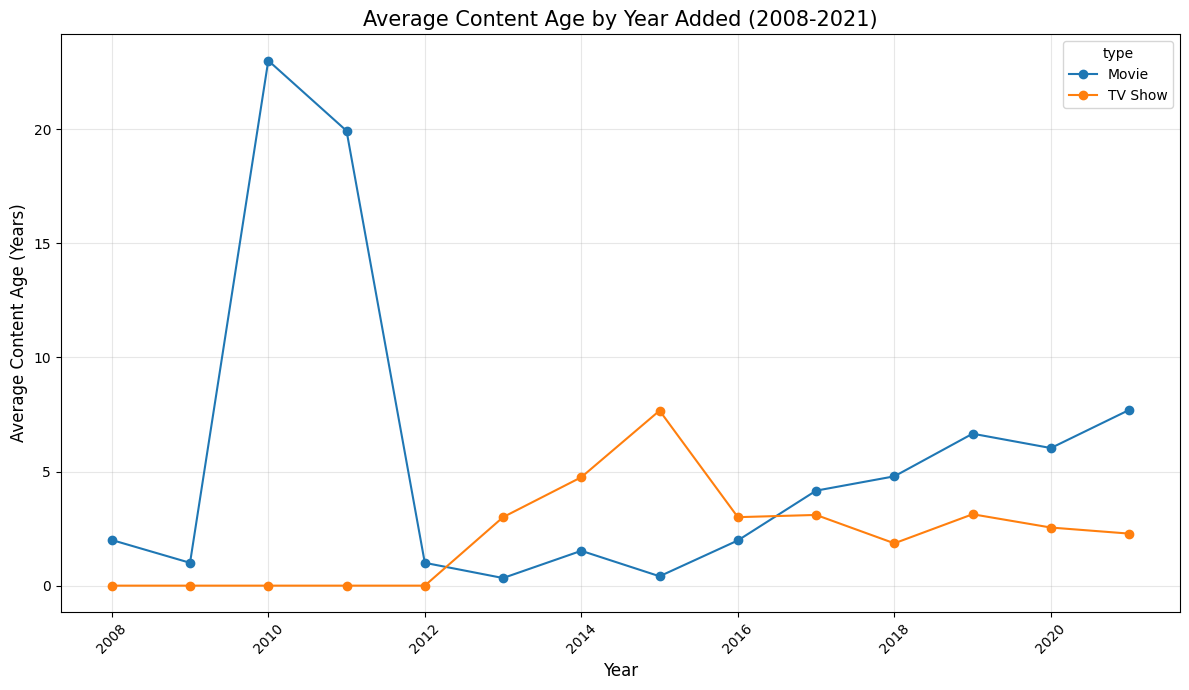

In [39]:
# Calculate average content age by year added
df_final['content_age'] = df_final['year_added'] - df_final['release_year']
avg_age_by_year = df_final.groupby(['year_added', 'type'])['content_age'].mean().unstack().fillna(0)

# Plotting average content age over time
fig4, ax4 = plt.subplots(figsize=(12, 7))
avg_age_by_year.plot(kind='line', marker='o', ax=ax4)
ax4.set_title('Average Content Age by Year Added (2008-2021)', fontsize=15)
ax4.set_xlabel('Year', fontsize=12)
ax4.set_ylabel('Average Content Age (Years)', fontsize=12)
ax4.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

Early period volatility (2008-2012): 
- Movies show dramatic fluctuation, with a notable spike around 2010 when Netflix added significantly older movie content (averaging over 20 years old) 
- This was followed by a sharp decline by 2012, suggesting a strategy shift 
- TV shows during this early period were consistently very new (close to 0 years old) 

Middle period (2013-2016): 
- Interesting reversal around 2014, where TV shows temporarily became older on average (4-5 years) than movies 
- Movies hit their lowest average age (~0.5 years) around 2015 

Recent trend (2017-2021): 
- Clear divergence in strategy between content types 
- Movies show a steady increase in average age, reaching ~7-8 years by 2021 
- TV shows maintain a consistently lower average age (1.5-2 years) 

This suggests Netflix focuses on newer TV content while being more willing to add older movies

#### What are the top countries contributing to netflix's growth?

In [40]:
# Function to extract the countries
def extract_main_country(country_list):
    """Extract the first country from a comma-separated list."""
    if pd.isna(country_list):
        return "Unknown"
    countries = country_list.split(", ")
    return countries[0].strip()

In [41]:
df_final['main_country'] = df_final['country'].apply(extract_main_country)

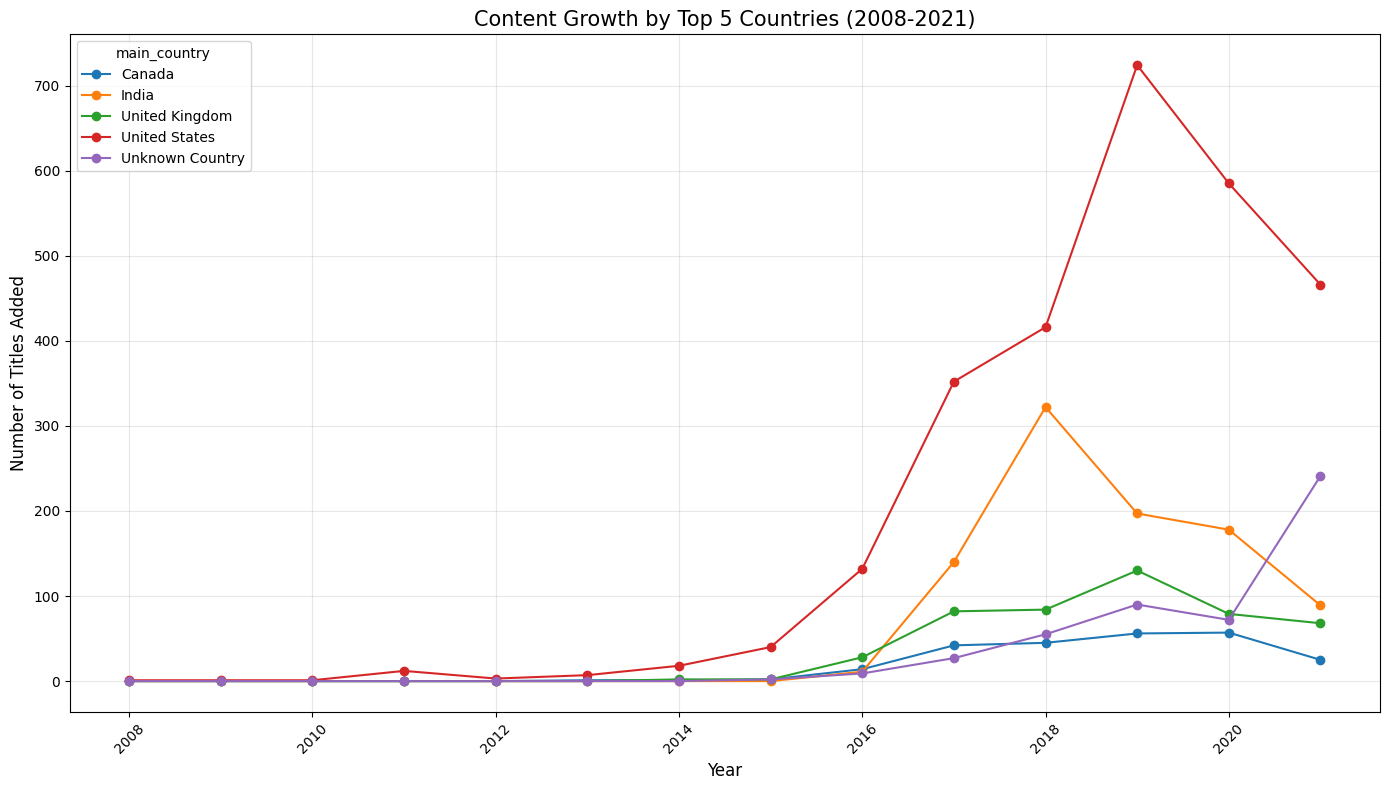

In [42]:
# Get yearly content additions by top 5 countries
top5_countries = df_final['main_country'].value_counts().head(5).index.tolist()
country_year_pivot = pd.pivot_table(
    df_final[df_final['main_country'].isin(top5_countries)],
    index='year_added',
    columns='main_country',
    values='show_id',
    aggfunc='count'
).fillna(0)

# Plotting regional growth
fig6, ax6 = plt.subplots(figsize=(14, 8))
country_year_pivot.plot(kind='line', marker='o', ax=ax6)
ax6.set_title('Content Growth by Top 5 Countries (2008-2021)', fontsize=15)
ax6.set_xlabel('Year', fontsize=12)
ax6.set_ylabel('Number of Titles Added', fontsize=12)
ax6.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()

Dominance of the United States: 
- The U.S. has the steepest growth curve, adding significantly more content than other countries. 
- This aligns with Netflix’s origin as a U.S.-based company and its heavy investment in American-produced shows/movies. 
- Strategic Takeaway: 
    - Netflix’s content strategy remains U.S.-centric, likely due to high domestic demand and production infrastructure. 

Rapid Growth in India: 
- India shows a sharp upward trend, especially post-2018, reflecting Netflix’s aggressive expansion into the Indian market. 
- Possible drivers: 
    - Localization efforts (e.g., Hindi, Tamil, Telugu content). 
    - Affordable mobile plans to attract India’s price-sensitive audience. 
- Strategic Takeaway: 
    - India is a key growth market, and Netflix should continue investing in regional content. 
    
Steady but Slower Growth in UK, Canada: 
- United Kingdom & Canada: Moderate growth, likely due to shared language (English) and cultural overlap with the U.S. 
- Strategic Takeaway: 
    - UK/Canada: More co-productions with the U.S. could boost output.

#### How is content volume, age and duration related to different countries?

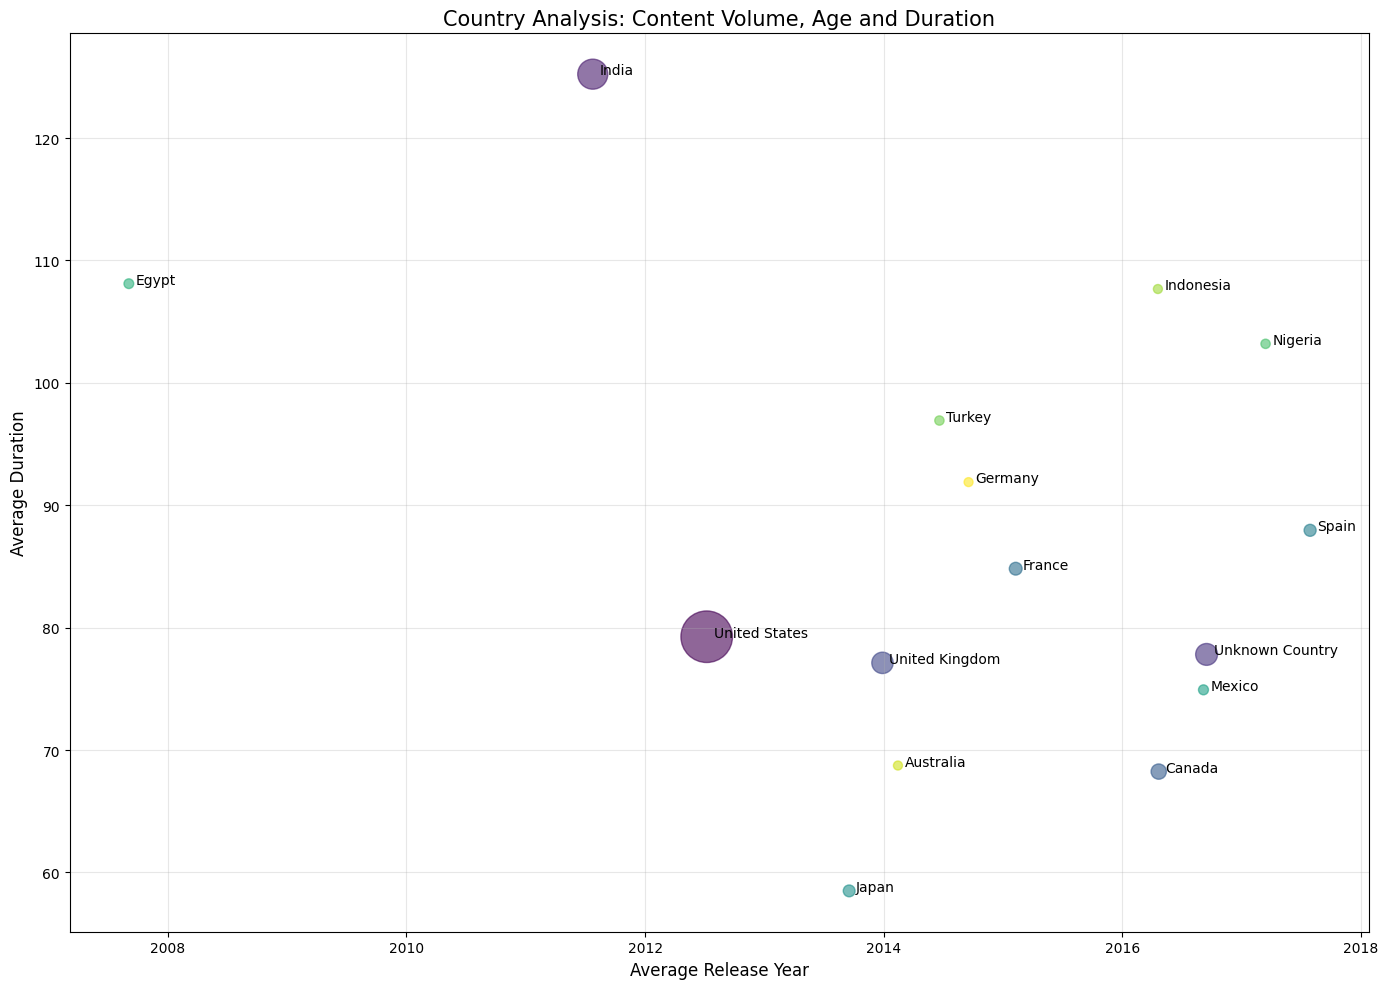

In [43]:
country_stats = df_final.groupby('main_country').agg({
    'show_id': 'count',
    'duration_value': 'mean',
    'release_year': 'mean'
}).reset_index()
country_stats = country_stats.sort_values('show_id', ascending=False).head(15)

# Create bubble chart
plt.figure(figsize=(14, 10))
plt.scatter(country_stats['release_year'], 
           country_stats['duration_value'], 
           s=country_stats['show_id']*0.5, # Scale bubble size 
           alpha=0.6, 
           c=range(len(country_stats)), # Color by index
           cmap='viridis')

# Add country labels
for i, row in country_stats.iterrows():
    plt.annotate(row['main_country'], 
                xy=(row['release_year'], row['duration_value']),
                xytext=(5, 0), 
                textcoords='offset points')

plt.title('Country Analysis: Content Volume, Age and Duration', fontsize=15)
plt.xlabel('Average Release Year', fontsize=12)
plt.ylabel('Average Duration', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()

Content Volume: 
- United States has the largest bubble, indicating the highest number of titles (consistent with prior analysis). 
- India, Unknown Country, and UK follow, reinforcing their dominance in Netflix’s catalog. 
- Smaller bubbles suggest fewer titles but potential niche audiences. 

Average Release Year: 
- Most countries cluster between 2012–2018, reflecting Netflix’s focus on recent content. 
- Egypt and India have older average release years (~2008–2010), likely due to reliance on classic films or slower updates in these markets. 
- Unknown Country (data gaps) skews newer, possibly from recent originals with unlisted countries. 

Average Duration: 
- Egypt and India have the highest average durations (~100–120 mins), typical of Bollywood and Arabic films. 
- UK, US, and Canada fall in the middle (~80–90 mins), balancing movies and TV shows (episode lengths averaged). 
- Germany and France have shorter durations (~60–70 mins), possibly due to more TV shows or concise European films.

#### Delving deep into netflix's content duration and it's age

In [44]:
df_final['genres'] = df_final['listed_in'].str.split(', ')

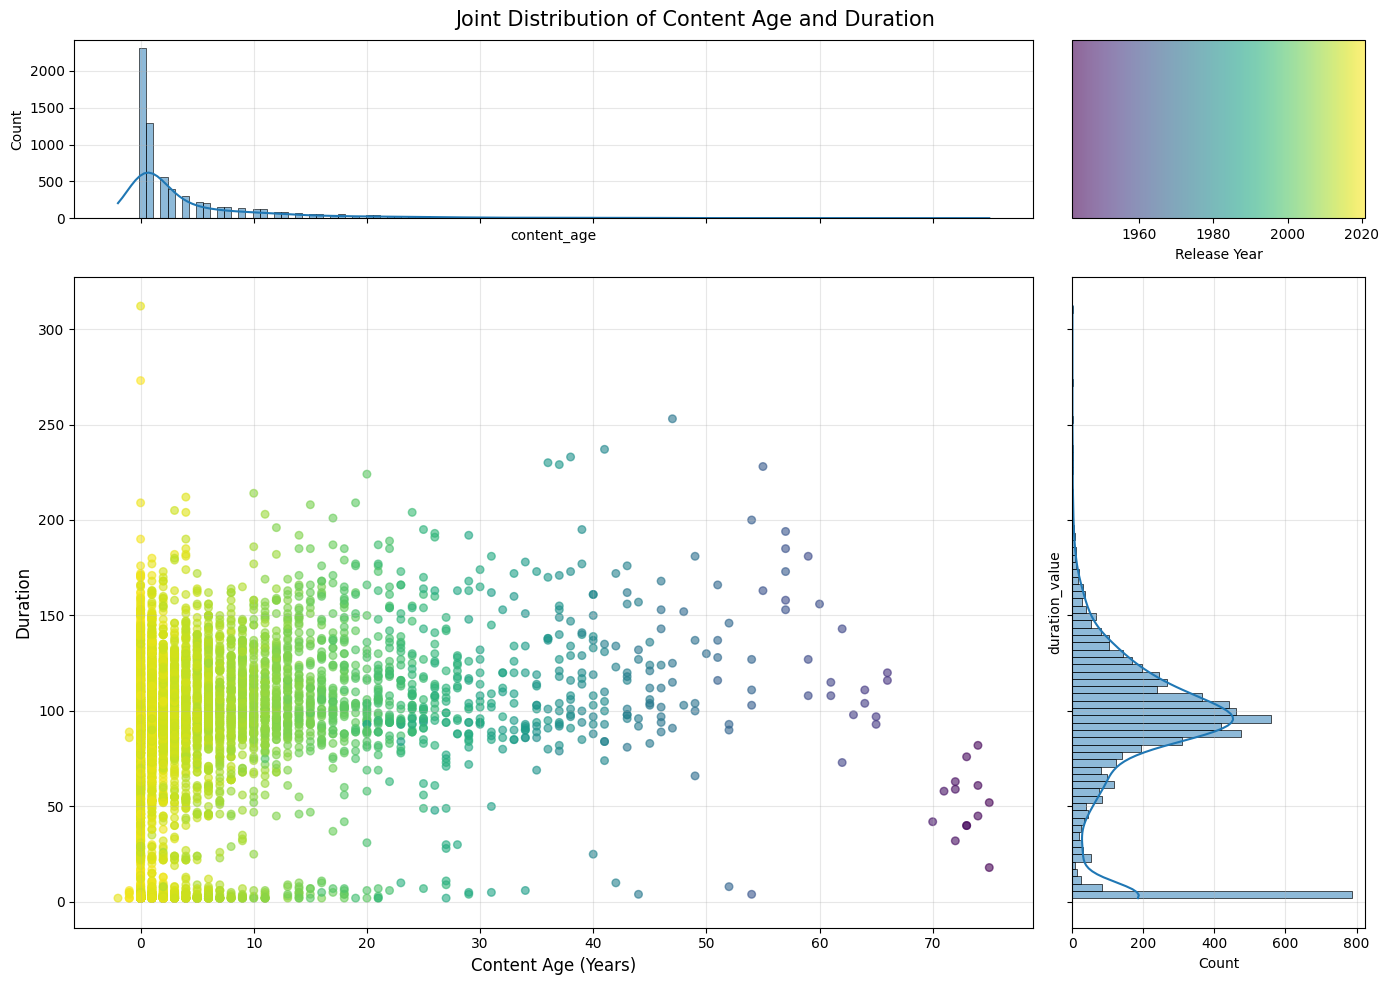

In [47]:
# Joint Plot with Histograms for Content Duration and Age
plt.figure(figsize=(14, 10))

# Create figure with grid for multiple charts
gs = plt.GridSpec(4, 4)

# Main scatter plot
ax_main = plt.subplot(gs[1:4, 0:3])
scatter = ax_main.scatter(df_final['content_age'], df_final['duration_value'], 
                         c=df_final['release_year'], cmap='viridis', 
                         alpha=0.6, s=30)

ax_main.set_xlabel('Content Age (Years)', fontsize=12)
ax_main.set_ylabel('Duration', fontsize=12)
ax_main.grid(alpha=0.3)

# X-axis histogram
ax_x = plt.subplot(gs[0, 0:3], sharex=ax_main)
sns.histplot(data=df_final, x='content_age', kde=True, ax=ax_x)
ax_x.set_ylabel('Count')
ax_x.grid(alpha=0.3)
plt.setp(ax_x.get_xticklabels(), visible=False)

# Y-axis histogram
ax_y = plt.subplot(gs[1:4, 3], sharey=ax_main)
sns.histplot(data=df_final, y='duration_value', kde=True, ax=ax_y)
ax_y.set_xlabel('Count')
ax_y.grid(alpha=0.3)
plt.setp(ax_y.get_yticklabels(), visible=False)

# Add colorbar to show release year
cbar_ax = plt.subplot(gs[0, 3])
cbar = plt.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Release Year')

plt.suptitle('Joint Distribution of Content Age and Duration', fontsize=15)
plt.tight_layout()

Content Age: Most titles are recent, with a peak around 2015–2020 (right-skewed histogram). This aligns with Netflix’s surge in original productions post-2010. 

Older content (pre-2000) is sparse but present, likely classic films or licensed catalog titles. 

Duration: 
- Bimodal distribution: Two clear peaks: 
    - ~90–120 mins: Dominated by movies (standard feature-length). 
    - ~30–60 mins: Likely TV show episodes (e.g., sitcoms, dramas).
    
- Few titles exceed 150 mins, suggesting Netflix avoids ultra-long formats (e.g., 3-hour films). 

- Scatter Plot Trends o	Newer content (yellow/green dots): Concentrated in shorter durations (TV shows and compact movies), reflecting modern viewing preferences
    - Older content (purple dots): Tends to be longer (classic films, Bollywood/Arabic cinema). 
    - Outliers: A few very old (pre-1980) but short titles—possibly documentaries or curated shorts.

#### Is there a correlation between content rating and average duration for different content type?

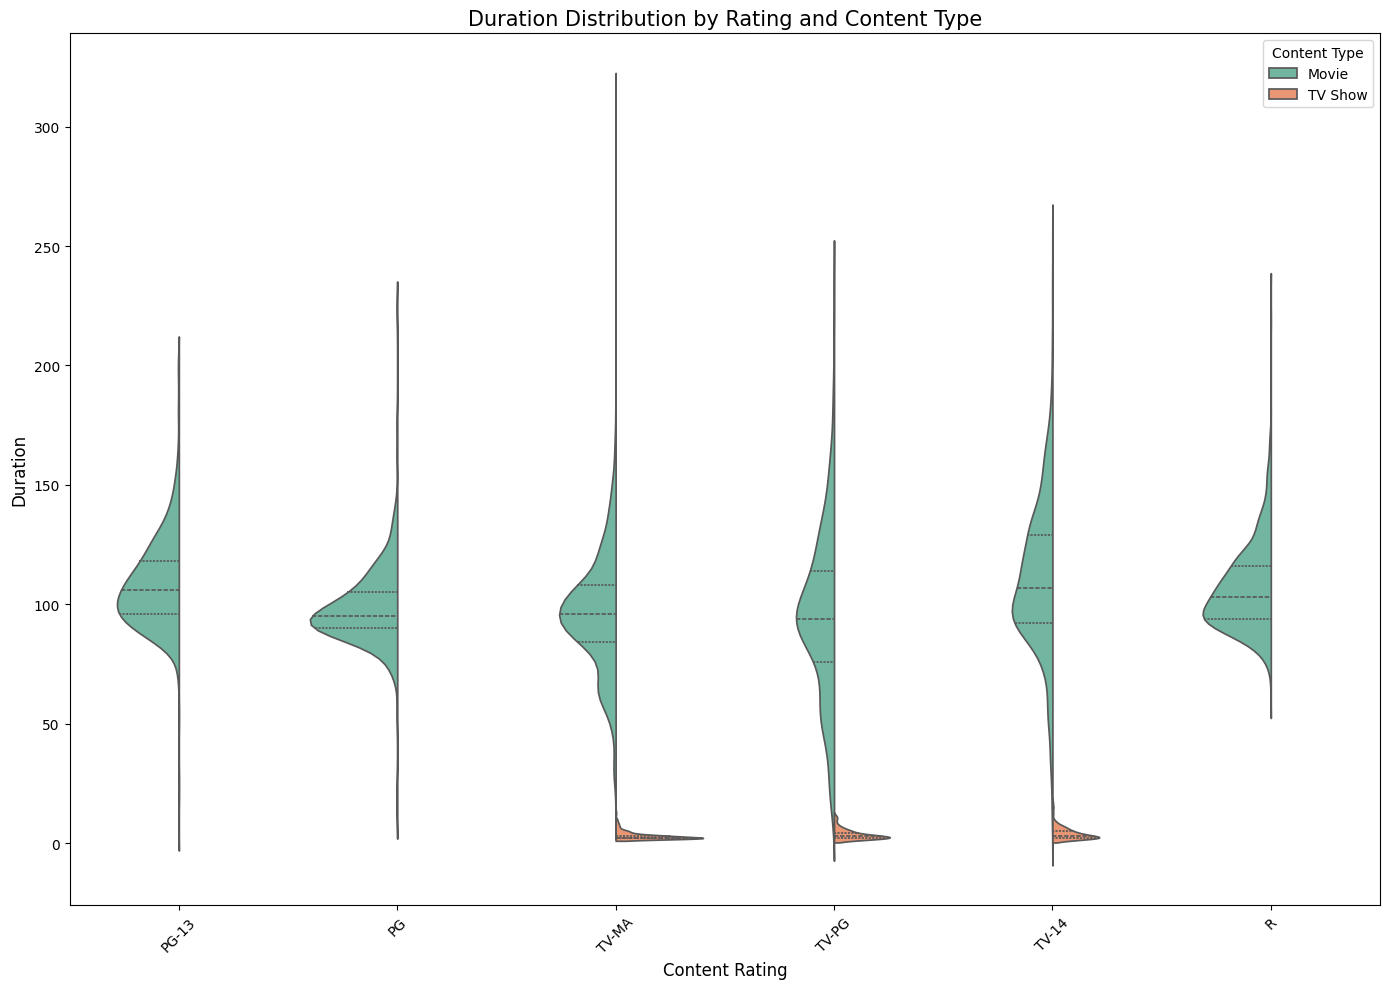

In [48]:
plt.figure(figsize=(14, 10))
top_ratings = df_final['rating'].value_counts().head(6).index

# Create violin plot
sns.violinplot(x='rating', y='duration_value', data=df_final[df_final['rating'].isin(top_ratings)], 
               hue='type', split=True, inner='quart', palette='Set2')

plt.title('Duration Distribution by Rating and Content Type', fontsize=15)
plt.xlabel('Content Rating', fontsize=12)
plt.ylabel('Duration', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Content Type')
plt.tight_layout()

Rating vs. Duration Trends: 
- TV-MA (Mature Audience): 
    - Movies: Longest durations (~90–120 mins), likely due to R-rated films (e.g., dramas, action). 
    - TV Shows: Shorter (~30–50 mins), typical of adult series (e.g., Stranger Things, The Witcher). 
    
- TV-14 (Teens): 
    - Movies: Moderate duration (~80–100 mins), targeting family-friendly blockbusters. 
    - TV Shows: Slightly longer than TV-MA (~40–60 mins), possibly due to teen dramas. 

- TV-PG (Parental Guidance): 
    - Movies: Shorter (~70–90 mins), often animated/kids’ films. 
    - TV Shows: Shortest (~20–40 mins), aligning with children’s programming. 

Outliers 
- A few TV-MA movies exceed 200 mins (e.g., epic films like The Irishman). 
- TV-PG/TV-G shows have minimal duration variance, reflecting strict runtime standards for kids’ content.

#### What Explains the Significant Duration Differences Between Content Genres?

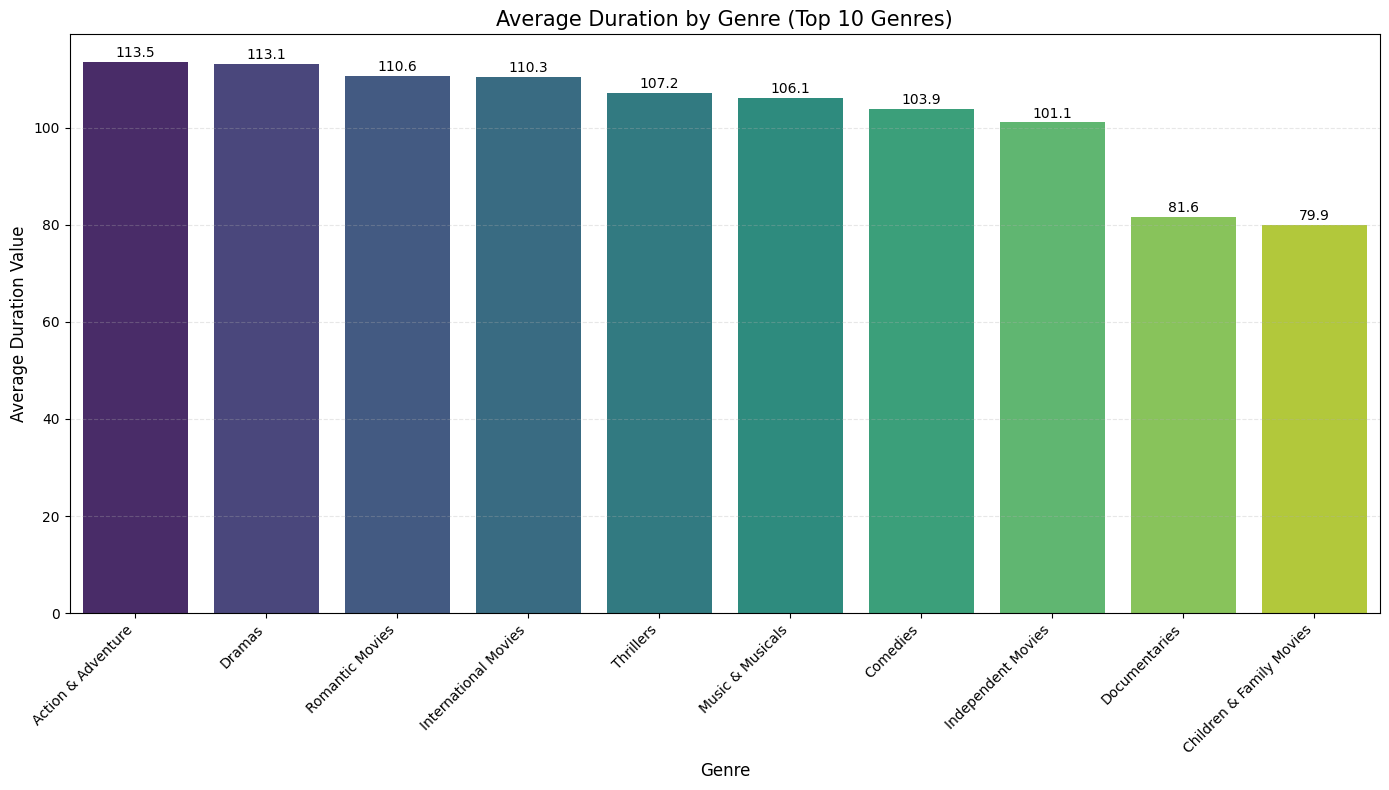

In [49]:
# Explode the genres list to get one row per genre
exploded_df = df_final.explode('genres')

# Get top 10 genres for better visualization
top_genres = exploded_df['genres'].value_counts().head(10).index.tolist()
genre_duration = exploded_df[exploded_df['genres'].isin(top_genres)]

# Calculate average duration for each genre
genre_avg_duration = genre_duration.groupby('genres')['duration_value'].mean().sort_values(ascending=False)

# Create the bar graph
plt.figure(figsize=(14, 8))
bars = sns.barplot(x=genre_avg_duration.index, y=genre_avg_duration.values, palette='viridis', hue = genre_avg_duration.index, legend = False)

# Add value labels on top of each bar
for i, v in enumerate(genre_avg_duration.values):
    bars.text(i, v + 1, f'{v:.1f}', ha='center', fontsize=10)

# Set labels and title
plt.title('Average Duration by Genre (Top 10 Genres)', fontsize=15)
plt.xlabel('Genre', fontsize=12)
plt.ylabel('Average Duration Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.tight_layout()

Average Duration by Genre: Longest-Duration Genres (100+ mins)
- Documentaries: ~113.5 mins (typical for in-depth, feature-length docs). 
- International Movies: ~113.1 mins (often include foreign cinema with longer runtimes). 
- Dramas: ~110.6 mins (character-driven narratives require extended storytelling). Moderate-Duration Genres (80–100 mins) 
- Comedies: ~107.2 mins (standard movie length for comedic narratives). 
- Action & Adventure: ~106.1 mins (blockbuster films with extended sequences). Shortest-Duration Genres (<80 mins) 
- Children & Family: ~81.6 mins (shorter attention spans, kid-friendly pacing)

In [51]:
df_final.to_csv("netflix-dataset-final.csv")